# IMPORTS

In [1]:
from warnings import filterwarnings
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import lightgbm as lgb
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Cluster import Butina
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
import operator

In [2]:
from rdkit import Chem                                                                                                                                                                   
from rdkit import RDLogger                                                                                                                                                                                                                                                                                                                         
RDLogger.DisableLog('rdApp.*')                                                                                                                                                                                                                                                                                                                      

In [3]:
features_list = ['vec_1', 'vec_2', 'vec_3', 'vec_4', 'vec_11', 'vec_13', 'vec_14', 'vec_18', 'vec_19', 'vec_20', 'vec_32', 'vec_40', 'vec_46', 'vec_53', 'vec_54', 'vec_55', 'vec_56', 'vec_61', 'vec_62', 'vec_67', 'vec_71', 'vec_74', 'vec_77', 'vec_78', 'vec_79', 'vec_92', 'vec_94', 'vec_102', 'vec_103', 'vec_104', 'vec_105', 'vec_106', 'vec_109', 'vec_110', 'vec_112', 'vec_117', 'vec_120', 'vec_125', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'HeavyAtomMolWt', 'ExactMolWt', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'NOCount', 'NumAliphaticHeterocycles', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedHeterocycles', 'MolLogP', 'MolMR', 'fr_Ar_N', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_amide', 'fr_aniline', 'fr_bicyclic', 'fr_halogen', 'fr_imidazole', 'fr_morpholine', 'fr_piperdine', 'fr_pyridine', 'fr_thiazole', 'Asphericity', 'Eccentricity', 'InertialShapeFactor', 'RadiusOfGyration', 'SpherocityIndex', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3']
len(features_list)

173

# DATA LOADING

In [4]:
cardiac_df = pd.read_csv('train.csv', sep = ',')
cardiac_df
cardiac_df['index_conts'] = cardiac_df.index

In [5]:
labels = cardiac_df['activity'].to_list()

In [6]:
submission_df = pd.read_csv('test.csv', sep = ',')
submission_df

,id,smiles
0,0,Cc1ccc2c(N3CCN(CCc4cccc(N5CCNC5=O)c4)CC3)cccc2n1
1,1,COc1ccc(Oc2ccc(S(=O)(=O)C3(C(=O)NO)CCC4(CCNCC4...
2,2,CN1Cc2ccc(-c3ccc(C[C@@H](C#N)NC(=O)C4(N)CCOCC4...
3,3,O=C(NC1CC1c1ccccc1)N1CCC(c2ncon2)CC1
4,4,CNc1cc(CCN2CCN(CCc3ccc4c(c3)COC4=O)CC2)ccc1C#N
...,...,...
2027,2027,O=C(NC1CC1c1ccccc1)N1CCC(c2nc(-c3ncccn3)no2)CC1
2028,2028,Fc1ccc(-n2cc(C3CCN(CCN4CCNC4=S)CC3)c3ccccc32)cc1
2029,2029,O=S1(=O)c2ccccc2CCC12CCN(CCc1ccc(F)cc1F)CC2
2030,2030,COc1cccc2c1OC(c1ccc(OCCCN3CCCCC3)cc1)C(C)S2(=O)=O


# TRAIN-TEST split by clustering

## utils

In [7]:
# Функция для оценки танимото-коэффициентов между отпечатками
def tanimoto_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [8]:
def get_fingerprints(smiles_list):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in mols]
    return fingerprints

## prepare data

In [9]:
data = cardiac_df.copy()
smiles_list = data['smiles'].values

In [10]:
# Генерация отпечатков
fingerprints = get_fingerprints(smiles_list)

# Преобразование в numpy-массив для кластеризации
fingerprints_array = np.array([np.array(fp) for fp in tqdm(fingerprints)])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4216/4216 [00:06<00:00, 613.38it/s]


## smart clustering, cutoff=0.78

In [13]:
mols = [Chem.MolFromSmiles(s) for s in tqdm(smiles_list)]

# Calculate distance matrix
dists = []
n_mols = len(mols)

for i in range(1, n_mols):
    dist = DataStructs.cDataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i], returnDistance=True)
    dists.extend([x for x in dist])

cutoff = 0.78

# now cluster the data
cluster_indices = Butina.ClusterData(dists, n_mols, cutoff, isDistData=True)
cluster_mols = [operator.itemgetter(*cluster)(mols) for cluster in cluster_indices]
cluster_mols = [[c] if isinstance(c, Chem.rdchem.Mol) else c for c in cluster_mols]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4216/4216 [00:00<00:00, 4364.26it/s]


In [14]:
# Assuming `cluster_indices` is the output from Butina.ClusterData
cluster_names = [f"Cluster {i+1}" for i in range(len(cluster_indices))]

# Prepare data to map molecule indices to cluster names
data_ = []
for cluster_name, cluster in zip(cluster_names, cluster_indices):
    for mol_idx in cluster:
        data_.append((mol_idx, smiles_list[mol_idx], cluster_name))

# Create DataFrame
df_clusters = pd.DataFrame(data_, columns=["Index", "SMILES", "Cluster"])

# Integrate to data
data['cluster']=df_clusters.set_index('Index').Cluster
clusters = data['cluster']

## split

In [15]:
# Разделение кластеров на train и test, чтобы избежать пересечений схожих молекул
train_clusters, test_clusters = train_test_split(np.unique(clusters), test_size=0.2, random_state=42)

# Отбор молекул для train и test выборок на основе кластеров
train_data = data[data['cluster'].isin(train_clusters)].reset_index(drop=True)
test_data = data[data['cluster'].isin(test_clusters)].reset_index(drop=True)

In [16]:
print(train_data.shape)
print(test_data.shape)

(3350, 4)
(866, 4)


## test

### random

In [15]:
train_data_t, test_data_t = train_test_split(data, test_size=0.2, random_state=42)

train_fps = get_fingerprints(train_data_t['smiles'].tolist())
test_fps = get_fingerprints(test_data_t['smiles'].tolist())

# Рассчитываем среднее танимото-сходство между train и test выборками
similarities = []
for test_fp in test_fps:
    for train_fp in train_fps:
        similarities.append(tanimoto_similarity(test_fp, train_fp))

avg_similarity = np.mean(similarities)
print(f'Среднее танимото-сходство между train и test: {avg_similarity:.4f}')
print(f'Размер тестовой выборки: {round(len(test_data)/(len(test_data)+len(train_data)), 3)}')

Среднее танимото-сходство между train и test: 0.1251
Размер тестовой выборки: 0.205


### smart, cutoff=0.78

In [17]:
# Отбор молекул для train и test выборок на основе кластеров
train_data_t = data[data['cluster'].isin(train_clusters)].reset_index(drop=True)
test_data_t = data[data['cluster'].isin(test_clusters)].reset_index(drop=True)

# Проверка среднего танимото-сходства между train и test выборками
train_fps = get_fingerprints(train_data_t['smiles'].tolist())
test_fps = get_fingerprints(test_data_t['smiles'].tolist())

# Рассчитываем среднее танимото-сходство между train и test выборками
similarities = []
for test_fp in test_fps:
    for train_fp in train_fps:
        similarities.append(tanimoto_similarity(test_fp, train_fp))

avg_similarity = np.mean(similarities)
print(f'Среднее танимото-сходство между train и test: {avg_similarity:.4f}')
print(f'Размер тестовой выборки: {round(len(test_data)/(len(test_data)+len(train_data)), 3)}')

Среднее танимото-сходство между train и test: 0.1140
Размер тестовой выборки: 0.205


# FEATURE EXTRACTION

In [ ]:
# train_indices = train_data['index_conts']
# train_indices.index = train_data['index_conts']
# train_indices.to_frame().to_csv('train_indices.csv')

In [ ]:
# test_indices = test_data['index_conts']
# test_indices.index = test_data['index_conts']
# test_indices.to_frame().to_csv('test_indices.csv')

In [18]:
train_indices = train_data['index_conts'].values
test_indices = test_data['index_conts'].values

def train_test_takimoto(data, labels, train_indices, test_indices):
    
    X_train = data.iloc[train_indices]
    X_test = data.iloc[test_indices]
    
    y_train = [labels[i] for i in train_indices]
    y_test = [labels[i] for i in test_indices]
    
    return(X_train, X_test, y_train, y_test) 

In [19]:
def generate_features_from_smiles(df):
     
        
    smiles_list = df['smiles'].values
    
    from rdkit import RDLogger
    RDLogger.DisableLog('rdApp.*')

    #get features from smiles
    filterwarnings('ignore')
    molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

    #fingerprints using MorganGenerator
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=128) for mol in molecules]
    filterwarnings('default')

    #turn fingerprints into arrays
    fingerprint_arrays = [np.zeros((1,), dtype=int) for _ in fingerprints]
    for i, fp in enumerate(fingerprints):
        DataStructs.ConvertToNumpyArray(fp, fingerprint_arrays[i])

    #get descriptors for each molecule
    filterwarnings('ignore')
    descriptors = []
    #with tqdm
    for mol in tqdm(molecules):
        desc = [desc[1](mol) for desc in Descriptors.descList]
        descriptors.append(desc)
    filterwarnings('default')

    #combine fingerprints and descriptors into a single dataframe
    descriptor_names = [desc_name[0] for desc_name in Descriptors.descList]
    descriptors_df = pd.DataFrame(descriptors, columns=descriptor_names)
    data = pd.DataFrame(fingerprint_arrays, columns = [f'vec_{i}' for i in range(128)])
    data = pd.concat([data, descriptors_df], axis=1)
    #data = data.drop(columns = data.columns[data.nunique() == 1])
    return data

data = generate_features_from_smiles(cardiac_df)
data_for_submission = generate_features_from_smiles(submission_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2032/2032 [00:33<00:00, 61.56it/s]


In [20]:
data

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4211,1,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4212,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4213,1,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
data_for_submission

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,1,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2028,0,0,1,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2029,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2030,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [22]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors3D

## генерация 3d фичей

In [31]:
# D3_features = pd.DataFrame(columns = ['Asphericity',
#                                      'Eccentricity',
#                                      'InertialShapeFactor',
#                                      'RadiusOfGyration',
#                                      'SpherocityIndex',
#                                      'NPR1',
#                                      'NPR2',
#                                      'PMI1',
#                                      'PMI2',
#                                       "PMI3"
#                                      ])
# for ind in cardiac_df.index.to_list():
#     smiles = cardiac_df.loc[ind, 'smiles']
#     mol = Chem.MolFromSmiles(smiles)
#     mol = Chem.AddHs(mol)
#     AllChem.EmbedMolecule(mol, randomSeed=42)
#     AllChem.UFFOptimizeMolecule(mol) 

#     all_3d_descriptors = {
#     "Asphericity": Descriptors3D.Asphericity(mol),
#     "Eccentricity": Descriptors3D.Eccentricity(mol),
#     "InertialShapeFactor": Descriptors3D.InertialShapeFactor(mol),
#     "RadiusOfGyration": Descriptors3D.RadiusOfGyration(mol),
#     "SpherocityIndex": Descriptors3D.SpherocityIndex(mol),
#     "NPR1": Descriptors3D.NPR1(mol),  # Normalized principal moments ratio 1
#     "NPR2": Descriptors3D.NPR2(mol),  # Normalized principal moments ratio 2
#     "PMI1": Descriptors3D.PMI1(mol),  # Principle moment of inertia 1
#     "PMI2": Descriptors3D.PMI2(mol),  # Principle moment of inertia 2
#     "PMI3": Descriptors3D.PMI3(mol),  # Principle moment of inertia 3
#     }
#     D3_features_new = pd.DataFrame(all_3d_descriptors, index = [ind])
#     #print(D3_features_new)
#     D3_features = pd.concat([D3_features, D3_features_new], axis = 0)
#     print(D3_features.shape)

In [23]:
D3_features = pd.DataFrame(columns = ['Asphericity',
                                     'Eccentricity',
                                     'InertialShapeFactor',
                                     'RadiusOfGyration',
                                     'SpherocityIndex',
                                     'NPR1',
                                     'NPR2',
                                     'PMI1',
                                     'PMI2',
                                      "PMI3"
                                     ])
for ind in cardiac_df.index.to_list():
    smiles = cardiac_df.loc[ind, 'smiles']
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=42)
    try:
        AllChem.UFFOptimizeMolecule(mol) 
        all_3d_descriptors = {
    "Asphericity": Descriptors3D.Asphericity(mol),
    "Eccentricity": Descriptors3D.Eccentricity(mol),
    "InertialShapeFactor": Descriptors3D.InertialShapeFactor(mol),
    "RadiusOfGyration": Descriptors3D.RadiusOfGyration(mol),
    "SpherocityIndex": Descriptors3D.SpherocityIndex(mol),
    "NPR1": Descriptors3D.NPR1(mol),  # Normalized principal moments ratio 1
    "NPR2": Descriptors3D.NPR2(mol),  # Normalized principal moments ratio 2
    "PMI1": Descriptors3D.PMI1(mol),  # Principle moment of inertia 1
    "PMI2": Descriptors3D.PMI2(mol),  # Principle moment of inertia 2
    "PMI3": Descriptors3D.PMI3(mol),  # Principle moment of inertia 3
    }
        D3_features_new = pd.DataFrame(all_3d_descriptors, index = [ind])
        #print(D3_features_new)
        D3_features = pd.concat([D3_features, D3_features_new], axis = 0)
        print(D3_features.shape)
    except:
        print('failed')


/tmp/ipykernel_1482/3057441055.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  D3_features = pd.concat([D3_features, D3_features_new], axis = 0)


(1, 10)
(2, 10)
(3, 10)
(4, 10)
(5, 10)
(6, 10)
(7, 10)
(8, 10)
(9, 10)
(10, 10)
(11, 10)
(12, 10)
(13, 10)
(14, 10)
(15, 10)
(16, 10)
(17, 10)
(18, 10)
(19, 10)
(20, 10)
(21, 10)
(22, 10)
(23, 10)
(24, 10)
(25, 10)
(26, 10)
(27, 10)
(28, 10)
(29, 10)
(30, 10)
(31, 10)
(32, 10)
(33, 10)
(34, 10)
(35, 10)
(36, 10)
(37, 10)
(38, 10)
(39, 10)
(40, 10)
(41, 10)
(42, 10)
failed
(43, 10)
(44, 10)
(45, 10)
(46, 10)
(47, 10)
(48, 10)
(49, 10)
(50, 10)
(51, 10)
(52, 10)
(53, 10)
(54, 10)
(55, 10)
(56, 10)
(57, 10)
(58, 10)
(59, 10)
(60, 10)
(61, 10)
(62, 10)
(63, 10)
(64, 10)
(65, 10)
(66, 10)
(67, 10)
(68, 10)
(69, 10)
(70, 10)
(71, 10)
(72, 10)
(73, 10)
(74, 10)
(75, 10)
(76, 10)
(77, 10)
(78, 10)
(79, 10)
(80, 10)
(81, 10)
(82, 10)
(83, 10)
(84, 10)
(85, 10)
(86, 10)
(87, 10)
(88, 10)
(89, 10)
(90, 10)
(91, 10)
(92, 10)
(93, 10)
(94, 10)
(95, 10)
(96, 10)
(97, 10)
(98, 10)
(99, 10)
(100, 10)
(101, 10)
(102, 10)
(103, 10)
(104, 10)
(105, 10)
(106, 10)
(107, 10)
(108, 10)
(109, 10)
(110, 10)
(

(830, 10)
(831, 10)
(832, 10)
(833, 10)
(834, 10)
(835, 10)
(836, 10)
(837, 10)
(838, 10)
(839, 10)
(840, 10)
(841, 10)
(842, 10)
(843, 10)
(844, 10)
(845, 10)
(846, 10)
(847, 10)
(848, 10)
(849, 10)
(850, 10)
(851, 10)
(852, 10)
(853, 10)
(854, 10)
(855, 10)
(856, 10)
(857, 10)
(858, 10)
(859, 10)
(860, 10)
(861, 10)
(862, 10)
(863, 10)
(864, 10)
(865, 10)
(866, 10)
(867, 10)
(868, 10)
(869, 10)
(870, 10)
(871, 10)
(872, 10)
(873, 10)
(874, 10)
(875, 10)
(876, 10)
(877, 10)
(878, 10)
(879, 10)
(880, 10)
(881, 10)
(882, 10)
(883, 10)
(884, 10)
(885, 10)
(886, 10)
(887, 10)
(888, 10)
(889, 10)
(890, 10)
(891, 10)
(892, 10)
(893, 10)
(894, 10)
(895, 10)
(896, 10)
(897, 10)
(898, 10)
(899, 10)
(900, 10)
(901, 10)
(902, 10)
(903, 10)
(904, 10)
(905, 10)
(906, 10)
(907, 10)
(908, 10)
(909, 10)
(910, 10)
(911, 10)
(912, 10)
(913, 10)
(914, 10)
(915, 10)
(916, 10)
(917, 10)
(918, 10)
(919, 10)
(920, 10)
(921, 10)
(922, 10)
(923, 10)
(924, 10)
(925, 10)
(926, 10)
(927, 10)
(928, 10)
(929, 10)


(1591, 10)
(1592, 10)
(1593, 10)
(1594, 10)
(1595, 10)
(1596, 10)
(1597, 10)
(1598, 10)
(1599, 10)
(1600, 10)
(1601, 10)
(1602, 10)
(1603, 10)
(1604, 10)
(1605, 10)
(1606, 10)
(1607, 10)
(1608, 10)
(1609, 10)
(1610, 10)
(1611, 10)
(1612, 10)
(1613, 10)
(1614, 10)
(1615, 10)
(1616, 10)
(1617, 10)
(1618, 10)
(1619, 10)
(1620, 10)
(1621, 10)
(1622, 10)
(1623, 10)
(1624, 10)
(1625, 10)
(1626, 10)
(1627, 10)
(1628, 10)
(1629, 10)
(1630, 10)
(1631, 10)
(1632, 10)
(1633, 10)
(1634, 10)
(1635, 10)
(1636, 10)
(1637, 10)
(1638, 10)
(1639, 10)
(1640, 10)
(1641, 10)
(1642, 10)
(1643, 10)
(1644, 10)
(1645, 10)
(1646, 10)
(1647, 10)
(1648, 10)
(1649, 10)
(1650, 10)
(1651, 10)
(1652, 10)
(1653, 10)
(1654, 10)
(1655, 10)
(1656, 10)
(1657, 10)
(1658, 10)
(1659, 10)
(1660, 10)
(1661, 10)
(1662, 10)
(1663, 10)
(1664, 10)
(1665, 10)
(1666, 10)
(1667, 10)
(1668, 10)
(1669, 10)
(1670, 10)
(1671, 10)
(1672, 10)
(1673, 10)
(1674, 10)
(1675, 10)
(1676, 10)
(1677, 10)
(1678, 10)
(1679, 10)
(1680, 10)
(1681, 10)

(2336, 10)
(2337, 10)
(2338, 10)
(2339, 10)
(2340, 10)
(2341, 10)
(2342, 10)
(2343, 10)
(2344, 10)
(2345, 10)
(2346, 10)
(2347, 10)
(2348, 10)
(2349, 10)
(2350, 10)
(2351, 10)
(2352, 10)
(2353, 10)
(2354, 10)
(2355, 10)
(2356, 10)
(2357, 10)
(2358, 10)
(2359, 10)
(2360, 10)
(2361, 10)
(2362, 10)
(2363, 10)
(2364, 10)
(2365, 10)
(2366, 10)
(2367, 10)
(2368, 10)
(2369, 10)
(2370, 10)
(2371, 10)
(2372, 10)
(2373, 10)
(2374, 10)
(2375, 10)
(2376, 10)
(2377, 10)
(2378, 10)
(2379, 10)
(2380, 10)
(2381, 10)
(2382, 10)
(2383, 10)
(2384, 10)
(2385, 10)
(2386, 10)
(2387, 10)
(2388, 10)
(2389, 10)
(2390, 10)
(2391, 10)
(2392, 10)
(2393, 10)
(2394, 10)
(2395, 10)
(2396, 10)
(2397, 10)
(2398, 10)
(2399, 10)
(2400, 10)
(2401, 10)
(2402, 10)
(2403, 10)
(2404, 10)
(2405, 10)
(2406, 10)
(2407, 10)
(2408, 10)
(2409, 10)
(2410, 10)
(2411, 10)
(2412, 10)
(2413, 10)
(2414, 10)
(2415, 10)
(2416, 10)
(2417, 10)
(2418, 10)
(2419, 10)
(2420, 10)
(2421, 10)
(2422, 10)
(2423, 10)
(2424, 10)
(2425, 10)
(2426, 10)

(3082, 10)
(3083, 10)
(3084, 10)
(3085, 10)
(3086, 10)
(3087, 10)
(3088, 10)
(3089, 10)
(3090, 10)
(3091, 10)
(3092, 10)
(3093, 10)
(3094, 10)
(3095, 10)
(3096, 10)
(3097, 10)
(3098, 10)
(3099, 10)
(3100, 10)
(3101, 10)
(3102, 10)
(3103, 10)
(3104, 10)
(3105, 10)
(3106, 10)
(3107, 10)
(3108, 10)
(3109, 10)
(3110, 10)
(3111, 10)
(3112, 10)
(3113, 10)
(3114, 10)
(3115, 10)
(3116, 10)
(3117, 10)
(3118, 10)
(3119, 10)
(3120, 10)
(3121, 10)
(3122, 10)
(3123, 10)
(3124, 10)
(3125, 10)
(3126, 10)
(3127, 10)
(3128, 10)
(3129, 10)
(3130, 10)
(3131, 10)
(3132, 10)
(3133, 10)
(3134, 10)
(3135, 10)
(3136, 10)
(3137, 10)
(3138, 10)
(3139, 10)
(3140, 10)
(3141, 10)
(3142, 10)
(3143, 10)
(3144, 10)
(3145, 10)
(3146, 10)
(3147, 10)
(3148, 10)
(3149, 10)
(3150, 10)
(3151, 10)
(3152, 10)
(3153, 10)
(3154, 10)
(3155, 10)
(3156, 10)
(3157, 10)
(3158, 10)
(3159, 10)
(3160, 10)
(3161, 10)
(3162, 10)
(3163, 10)
(3164, 10)
failed
(3165, 10)
(3166, 10)
(3167, 10)
(3168, 10)
(3169, 10)
(3170, 10)
(3171, 10)
(31

(3827, 10)
(3828, 10)
(3829, 10)
(3830, 10)
(3831, 10)
(3832, 10)
(3833, 10)
(3834, 10)
(3835, 10)
(3836, 10)
(3837, 10)
(3838, 10)
(3839, 10)
(3840, 10)
(3841, 10)
(3842, 10)
(3843, 10)
(3844, 10)
(3845, 10)
(3846, 10)
(3847, 10)
(3848, 10)
(3849, 10)
(3850, 10)
(3851, 10)
(3852, 10)
(3853, 10)
(3854, 10)
(3855, 10)
(3856, 10)
(3857, 10)
(3858, 10)
(3859, 10)
(3860, 10)
(3861, 10)
(3862, 10)
(3863, 10)
(3864, 10)
(3865, 10)
(3866, 10)
(3867, 10)
(3868, 10)
(3869, 10)
(3870, 10)
(3871, 10)
(3872, 10)
(3873, 10)
(3874, 10)
(3875, 10)
(3876, 10)
(3877, 10)
(3878, 10)
(3879, 10)
(3880, 10)
(3881, 10)
(3882, 10)
(3883, 10)
(3884, 10)
(3885, 10)
(3886, 10)
(3887, 10)
(3888, 10)
(3889, 10)
(3890, 10)
(3891, 10)
(3892, 10)
(3893, 10)
(3894, 10)
(3895, 10)
(3896, 10)
(3897, 10)
(3898, 10)
(3899, 10)
(3900, 10)
(3901, 10)
(3902, 10)
(3903, 10)
(3904, 10)
(3905, 10)
(3906, 10)
(3907, 10)
(3908, 10)
(3909, 10)
(3910, 10)
(3911, 10)
(3912, 10)
(3913, 10)
(3914, 10)
(3915, 10)
(3916, 10)
(3917, 10)

In [24]:
D3_features_cardiac = D3_features.copy()
D3_features_cardiac

,Asphericity,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex,NPR1,NPR2,PMI1,PMI2,PMI3
0,0.545326,0.982197,0.001065,3.985978,0.343830,0.187854,0.961625,903.212831,4623.540914,4808.051924
1,0.530796,0.981262,0.000523,4.753569,0.219698,0.192678,0.901736,1723.459623,8065.800919,8944.749559
2,0.599454,0.987278,0.000490,5.272766,0.163213,0.159004,0.938413,1916.360201,11310.035287,12052.294721
3,0.193324,0.897277,0.000436,3.631151,0.370062,0.441468,0.770253,1765.275272,3079.975865,3998.652808
4,0.672993,0.992234,0.000940,4.694921,0.171777,0.124386,0.924599,983.200537,7308.445662,7904.449804
...,...,...,...,...,...,...,...,...,...,...
4211,0.443820,0.970292,0.000144,6.301336,0.105846,0.241936,0.804622,5573.229230,18535.225536,23035.951942
4212,0.294482,0.935546,0.000155,5.137467,0.152498,0.353205,0.716423,4610.476869,9351.659935,13053.263789
4213,0.273708,0.931848,0.000391,4.020550,0.231487,0.362850,0.779826,1995.279160,4288.190324,5498.906993
4214,0.689497,0.993055,0.001884,4.016129,0.163193,0.117648,0.950022,504.232596,4071.741064,4285.945394


In [ ]:
# D3_features = pd.DataFrame(columns = ['Asphericity',
#                                      'Eccentricity',
#                                      'InertialShapeFactor',
#                                      'RadiusOfGyration',
#                                      'SpherocityIndex',
#                                      'NPR1',
#                                      'NPR2',
#                                      'PMI1',
#                                      'PMI2',
#                                       "PMI3"
#                                      ])
# for ind in submission_df.index.to_list():
#     smiles = submission_df.loc[ind, 'smiles']
#     mol = Chem.MolFromSmiles(smiles)
#     mol = Chem.AddHs(mol)
#     AllChem.EmbedMolecule(mol, randomSeed=42)
#     AllChem.UFFOptimizeMolecule(mol) 

#     all_3d_descriptors = {
#     "Asphericity": Descriptors3D.Asphericity(mol),
#     "Eccentricity": Descriptors3D.Eccentricity(mol),
#     "InertialShapeFactor": Descriptors3D.InertialShapeFactor(mol),
#     "RadiusOfGyration": Descriptors3D.RadiusOfGyration(mol),
#     "SpherocityIndex": Descriptors3D.SpherocityIndex(mol),
#     "NPR1": Descriptors3D.NPR1(mol),  # Normalized principal moments ratio 1
#     "NPR2": Descriptors3D.NPR2(mol),  # Normalized principal moments ratio 2
#     "PMI1": Descriptors3D.PMI1(mol),  # Principle moment of inertia 1
#     "PMI2": Descriptors3D.PMI2(mol),  # Principle moment of inertia 2
#     "PMI3": Descriptors3D.PMI3(mol),  # Principle moment of inertia 3
#     }
#     D3_features_new = pd.DataFrame(all_3d_descriptors, index = [ind])
#     #print(D3_features_new)
#     D3_features = pd.concat([D3_features, D3_features_new], axis = 0)
#     print(D3_features.shape)

In [27]:
D3_features_submission =  pd.read_csv('D3_features_submission.csv')
D3_features_submission

,Asphericity,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex,NPR1,NPR2,PMI1,PMI2,PMI3
0,0.634261,0.989498,0.000642,5.211860,0.274650,0.144550,0.984342,1532.824243,10438.110753,10604.145900
1,0.674215,0.992195,0.000640,5.210155,0.125964,0.124698,0.957653,1497.325629,11499.104361,12007.594929
2,0.818505,0.997886,0.001026,5.976159,0.076664,0.064994,0.976576,951.642877,14299.091413,14642.065691
3,0.755750,0.995935,0.001747,4.520133,0.168361,0.090072,0.973491,557.155109,6021.713078,6185.691154
4,0.830430,0.998175,0.001152,5.944957,0.106486,0.060387,0.976498,847.690419,13707.736027,14037.654306
...,...,...,...,...,...,...,...,...,...,...
2027,0.502964,0.978259,0.000484,4.881557,0.192918,0.207389,0.889871,1840.101453,7895.572497,8872.713676
2028,0.628048,0.989503,0.000501,5.413056,0.093433,0.144514,0.883398,1764.729161,10787.578854,12211.464536
2029,0.616607,0.988361,0.000904,4.368866,0.237528,0.152124,0.968887,1071.855014,6826.696166,7045.915074
2030,0.516426,0.979652,0.000412,5.115006,0.178127,0.200706,0.911916,2215.069928,10064.262642,11036.391072


In [29]:
features_all = pd.concat([data, D3_features_cardiac], axis = 1)
features_all_for_submission = pd.concat([data_for_submission, D3_features_submission], axis = 1)

In [ ]:
print(features_all.shape, features_all_for_submission.shape)

# LOGISTIC REGRESSION

In [19]:
# ## Train Test Split
# X_train, X_test, y_train, y_test = train_test_takimoto(data, labels, train_indices, test_indices)

In [20]:
#TODO remove columns automatically instead of manually

#in X_train and X_test replace nan with 0
# X_train = X_train.fillna(0)
# X_test = X_test.fillna(0)
# X_train.drop(['MaxPartialCharge', 'MaxAbsPartialCharge'],axis = 1, inplace = True)
# X_test.drop(['MaxPartialCharge', 'MaxAbsPartialCharge'], axis = 1, inplace = True)
# X_train.drop(['MinPartialCharge', 'MinAbsPartialCharge'],axis = 1, inplace = True)
# X_test.drop(['MinPartialCharge', 'MinAbsPartialCharge'], axis = 1, inplace = True)
# X_train.drop('Ipc', axis = 1, inplace = True)
# X_test.drop('Ipc', axis = 1, inplace = True)

In [21]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [22]:
# model = LogisticRegression(class_weight='balanced', max_iter = 1000)
# model.fit(X_train, y_train)
# y_pred = model.predict_proba(X_test)
# fpr_log, tpr_log, _ = roc_curve(y_test, y_pred[:,1])
# roc_auc_score(y_test, y_pred[:,1])

0.7006064992761942

# LIGHTGBM

In [96]:
# import shap

/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):


In [138]:
# # Train the base LightGBM model

# def feature_selection(X_train, y_train):
#     base_model = lgb.LGBMClassifier(random_state=42, 
#                                force_row_wise=True,
#                                        subsample=0.85,
#                                        colsample_bytree=0.75,
#                                        n_estimators=100,
#                                        class_weight='balanced')
#     base_model.fit(X_train, y_train)

#     # Calculate SHAP values for the base model
#     explainer = shap.TreeExplainer(base_model)
#     shap_values = explainer.shap_values(X_train)
#     print(shap_values.shape)
#     shap_sum = np.abs(shap_values).mean(axis=0)
#     print(shap_sum.shape)
#     importance_df = pd.DataFrame(
#         [X_train.columns.tolist(),
#          shap_sum.tolist()]).T
#     importance_df.columns = ['column_name', 'importance']
#     importance_df = importance_df.sort_values('importance', ascending=False)
#     genes_to_drop = list(importance_df[importance_df['importance'] == 0]['column_name'])
    
#     X_train = X_train.drop(genes_to_drop, axis = 1)
#     print('was dropped')
#     print(len(X_train.columns))
#     if len(X_train.columns) != 173:
#         feature_selection(X_train, y_train)
#     else:
#         print(X_train.columns.to_list())

In [139]:
# feature_selection(features_all, cardiac_df['activity'])

[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 25778
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 320
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 348)
(348,)
was dropped
258
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 25452
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 258
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 258)
(258,)
was dropped
240
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 25406
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 240)
(240,)
was dropped
225
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 25354
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 225)
(225,)
was dropped
213
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 25295
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 213)
(213,)
was dropped
204
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 25267
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 204)
(204,)
was dropped
200
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 25259
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 200)
(200,)
was dropped
194
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 24994
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 194
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 194)
(194,)
was dropped
192
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 24989
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 192)
(192,)
was dropped
187
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 24979
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 187)
(187,)
was dropped
182
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 24969
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 182)
(182,)
was dropped
179
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 24955
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


(4216, 179)
(179,)
was dropped
177
[LightGBM] [Info] Number of positive: 2463, number of negative: 1753
[LightGBM] [Info] Total Bins 24944
[LightGBM] [Info] Number of data points in the train set: 4216, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
(4216, 177)
(177,)
was dropped
173
['vec_1', 'vec_2', 'vec_3', 'vec_4', 'vec_11', 'vec_13', 'vec_14', 'vec_18', 'vec_19', 'vec_20', 'vec_32', 'vec_40', 'vec_46', 'vec_53', 'vec_54', 'vec_55', 'vec_56', 'vec_61', 'vec_62', 'vec_67', 'vec_71', 'vec_74', 'vec_77', 'vec_78', 'vec_79', 'vec_92', 'vec_94', 'vec_102', 'vec_103', 'vec_104', 'vec_105', 'vec_106', 'vec_109', 'vec_110', 'vec_112', 'vec_117', 'vec_120', 'vec_125', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'HeavyAtomMolWt', 'ExactMolWt', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'Fp

/opt/conda/envs/pytorch/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [ ]:
features_list = ['vec_1', 'vec_2', 'vec_3', 'vec_4', 'vec_11', 'vec_13', 'vec_14', 'vec_18', 'vec_19', 'vec_20', 'vec_32', 'vec_40', 'vec_46', 'vec_53', 'vec_54', 'vec_55', 'vec_56', 'vec_61', 'vec_62', 'vec_67', 'vec_71', 'vec_74', 'vec_77', 'vec_78', 'vec_79', 'vec_92', 'vec_94', 'vec_102', 'vec_103', 'vec_104', 'vec_105', 'vec_106', 'vec_109', 'vec_110', 'vec_112', 'vec_117', 'vec_120', 'vec_125', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'HeavyAtomMolWt', 'ExactMolWt', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'NOCount', 'NumAliphaticHeterocycles', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedHeterocycles', 'MolLogP', 'MolMR', 'fr_Ar_N', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_amide', 'fr_aniline', 'fr_bicyclic', 'fr_halogen', 'fr_imidazole', 'fr_morpholine', 'fr_piperdine', 'fr_pyridine', 'fr_thiazole', 'Asphericity', 'Eccentricity', 'InertialShapeFactor', 'RadiusOfGyration', 'SpherocityIndex', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3']
len(features_list)

## Train Test Split

## Optuna

In [31]:
features_all = features_all[features_list]

In [32]:
X_train, X_test, y_train, y_test = train_test_takimoto(features_all, labels, train_indices, test_indices)

In [ ]:
X_train

In [33]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'class_weight': 'balanced',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_pred[:,1])

import warnings
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
warnings.filterwarnings('default')

[I 2024-11-02 18:37:50,288] A new study created in memory with name: no-name-cc66030f-aaa3-4097-8450-6933adf1bed6
[I 2024-11-02 18:37:51,773] Trial 0 finished with value: 0.7808179004642339 and parameters: {'lambda_l1': 1.8158879913743894e-07, 'lambda_l2': 5.619494486191, 'num_leaves': 181, 'feature_fraction': 0.6040671817549976, 'bagging_fraction': 0.9253951873290446, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 0 with value: 0.7808179004642339.
[I 2024-11-02 18:37:52,403] Trial 1 finished with value: 0.8028658962711526 and parameters: {'lambda_l1': 0.031158434894022844, 'lambda_l2': 0.00179302651303759, 'num_leaves': 236, 'feature_fraction': 0.5330590648794619, 'bagging_fraction': 0.9761364301374433, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 1 with value: 0.8028658962711526.
[I 2024-11-02 18:37:53,081] Trial 2 finished with value: 0.7748402635651177 and parameters: {'lambda_l1': 0.4797219643742662, 'lambda_l2': 2.2801486808734545e-07, 'num_leaves': 225,

In [34]:
from sklearn.metrics import average_precision_score

In [28]:
#print the best hyperparameters
study.best_params

{'lambda_l1': 2.040753285115133e-06,
 'lambda_l2': 3.167358150824028e-05,
 'num_leaves': 167,
 'feature_fraction': 0.6039803210112938,
 'bagging_fraction': 0.907654356551017,
 'bagging_freq': 2,
 'min_child_samples': 18}

## Best Model

In [ ]:
#СТАЛО

In [35]:
#fit the best model
best_params = study.best_params
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred[:,1])
roc_auc_score(y_test, y_pred[:,1])

0.7740103828682673

In [36]:
#TODO incorporate cross-validation in optuna and best model, in the logreg too
from sklearn.model_selection import cross_val_score
cross_val_score(model, data, labels, cv = 5, scoring = 'roc_auc').mean()

0.9101369316319925

In [37]:
average_precision_score(y_test, y_pred[:,1])

0.8753157307936377

In [ ]:
#БЫЛО

In [29]:
#fit the best model
best_params = study.best_params
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred[:,1])
roc_auc_score(y_test, y_pred[:,1])

0.7771302351120651

In [30]:
#TODO incorporate cross-validation in optuna and best model, in the logreg too
from sklearn.model_selection import cross_val_score
cross_val_score(model, data, labels, cv = 5, scoring = 'roc_auc').mean()

0.9086278060041645

In [31]:
average_precision_score(y_test, y_pred[:,1])

0.8756078218493136

# ROC CURVES AND CONFUSION MATRICES

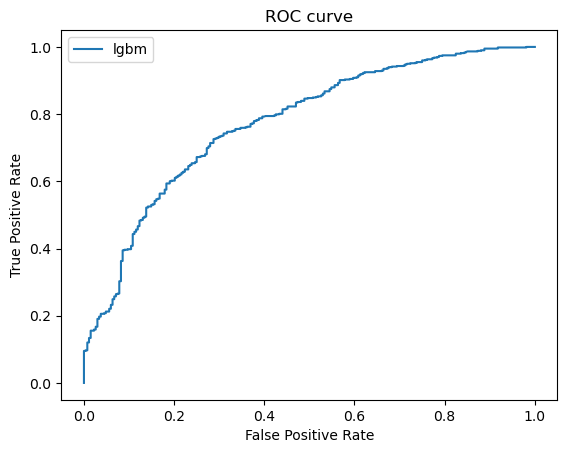

In [38]:
#draw both fpr and fpr_log
#plt.plot(fpr_log, tpr_log, label = 'logistic regression')
plt.plot(fpr_lgbm, tpr_lgbm, label = 'lgbm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

# GENERATING THE SUBMISSION

In [33]:
# data_for_submission = pd.read_csv('processed_data_for_submission.csv', sep = ',', index_col = 0)

In [40]:
features_all_for_submission = features_all_for_submission[features_list]

In [41]:
best_params = study.best_params
model = lgb.LGBMClassifier(**best_params)
model.fit(features_all, labels)

LGBMClassifier(bagging_fraction=0.9761364301374433, bagging_freq=3,
               feature_fraction=0.5330590648794619,
               lambda_l1=0.031158434894022844, lambda_l2=0.00179302651303759,
               min_child_samples=66, num_leaves=236)

(array([104., 117., 121., 110., 135., 148., 178., 215., 300., 604.]),
 array([0.00991557, 0.10870276, 0.20748994, 0.30627713, 0.40506431,
        0.5038515 , 0.60263868, 0.70142587, 0.80021305, 0.89900024,
        0.99778743]),
 <BarContainer object of 10 artists>)

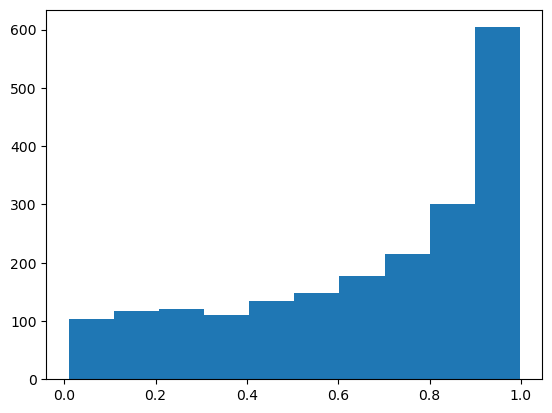

In [42]:
y_pred = model.predict_proba(features_all_for_submission)
plt.hist(y_pred[:, 1])

In [38]:
submission = pd.DataFrame(y_pred[:,1]).reset_index()
submission.columns = ['id', 'activity']
submission = submission.set_index('id')
submission

,activity
id,
0,0.994062
1,0.360163
2,0.120902
3,0.784611
4,0.935042
...,...
2027,0.714829
2028,0.996073
2029,0.960748


In [39]:
submission.to_csv('post__submission.csv')

## Additional Technical checks


In [40]:
best_params = study.best_params
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

In [41]:
y_pred[:,1]

array([3.41805542e-01, 9.81289055e-01, 8.53943408e-01, 2.48174147e-02,
       9.63138562e-01, 6.77235908e-01, 9.77266208e-01, 9.56943963e-02,
       9.04196414e-01, 9.94349100e-01, 2.25268307e-01, 6.54018984e-01,
       7.94709681e-01, 9.82150858e-01, 8.93289947e-01, 6.61097956e-01,
       9.06594421e-01, 9.54991236e-01, 9.90352609e-01, 9.25339013e-01,
       8.40767659e-01, 9.92460404e-01, 9.95625038e-01, 9.53003833e-01,
       8.18274674e-01, 7.40436633e-01, 3.43458539e-01, 7.63130266e-01,
       6.88003043e-01, 9.88325148e-01, 9.85232767e-01, 9.98139951e-01,
       9.41488384e-01, 9.82022457e-01, 2.94779433e-01, 9.87123241e-01,
       8.85468391e-01, 4.90887868e-01, 9.43358196e-01, 9.81959232e-01,
       9.90900093e-01, 6.42645694e-01, 9.98229502e-01, 9.94005651e-01,
       9.59282139e-01, 9.91867924e-01, 9.74933913e-01, 9.80957289e-01,
       7.70765899e-02, 8.41036101e-01, 9.94848039e-01, 1.09472291e-01,
       9.38863841e-01, 4.42191965e-01, 8.25260180e-02, 8.25564693e-01,
      

(array([ 86.,  45.,  33.,  49.,  41.,  30.,  59.,  70.,  77., 376.]),
 array([9.31598333e-04, 1.00804374e-01, 2.00677151e-01, 3.00549927e-01,
        4.00422703e-01, 5.00295479e-01, 6.00168255e-01, 7.00041031e-01,
        7.99913807e-01, 8.99786583e-01, 9.99659359e-01]),
 <BarContainer object of 10 artists>)

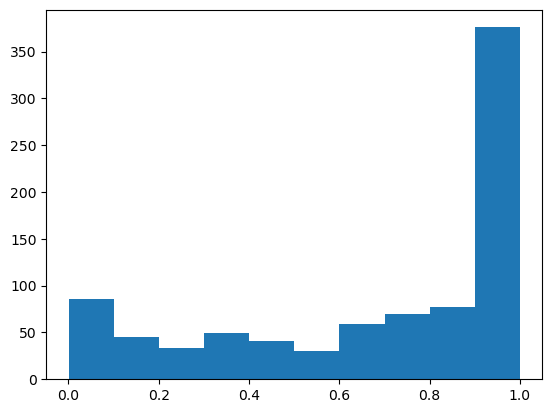

In [42]:
plt.hist(y_pred[:, 1])

In [43]:
# скаффолд смайлы для генерации доп фичей
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
for ind in cardiac_df.index.to_list():
    smiles = cardiac_df.loc[ind, 'smiles']
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    scaffold_smiles = Chem.MolToSmiles(scaffold)
    cardiac_df.loc[ind, 'scaffold_smile'] = scaffold_smiles

In [44]:
scaffolds = [dm.to_scaffold_murcko(mol) for mol in mol_list]

dm.to_image(scaffolds, mol_size=(200, 150))

NameError: name 'mol_list' is not defined